<a href="https://colab.research.google.com/github/Aye-Nyein-Thaw/Building-Footprint-Extraction-Practical-Project/blob/toby/Unet_Sample_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images & Masks Directory List

In [ ]:
img_size = (512, 512)
num_classes = 2
batch_size = 1

In [ ]:
# make lists for image and mask directories

import os
all_list = os.listdir('/content/sample_data')

input_img_paths = sorted(['/content/sample_data/' + img for img in all_list if 'processed_' in img])
target_img_paths = sorted(['/content/sample_data/'+ img for img in all_list if 'mask_' in img])

print(input_img_paths)
print(target_img_paths)

['/content/sample_data/processed_image+final_00001_a0.png', '/content/sample_data/processed_image+final_00002_a0.png', '/content/sample_data/processed_image+final_00003_a0.png', '/content/sample_data/processed_image+final_00004_a0.png', '/content/sample_data/processed_image+final_00005_a0.png', '/content/sample_data/processed_image+final_00006_a0.png', '/content/sample_data/processed_image+final_00007_a0.png', '/content/sample_data/processed_image+final_00008_a0.png', '/content/sample_data/processed_image+final_00009_a0.png', '/content/sample_data/processed_image+final_00010_a0.png', '/content/sample_data/processed_image+final_00011_a0.png', '/content/sample_data/processed_image+final_00012_a0.png', '/content/sample_data/processed_image+final_00013_a0.png', '/content/sample_data/processed_image+final_00014_a0.png', '/content/sample_data/processed_image+final_00015_a0.png', '/content/sample_data/processed_image+final_00016_a0.png', '/content/sample_data/processed_image+final_00017_a0.pn

# Prepare Sequence class to load & vectorize batches of data

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

        return x, y

# Create Model

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
#model.summary()

# Prepare Data Generators

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 2
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# Train Model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 1000
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, verbose = 1)

Epoch 1/1000
18/18 [==============================] - 4s 109ms/step - loss: 0.1307 - val_loss: 0.2062


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/1000
18/18 [==============================] - 1s 81ms/step - loss: 0.0826 - val_loss: 0.2764
Epoch 3/1000
18/18 [==============================] - 1s 82ms/step - loss: 0.0784 - val_loss: 0.1768
Epoch 4/1000
18/18 [==============================] - 1s 82ms/step - loss: 0.0677 - val_loss: 0.2636
Epoch 5/1000
18/18 [==============================] - 1s 82ms/step - loss: 0.0488 - val_loss: 0.2881
Epoch 6/1000
18/18 [==============================] - 1s 81ms/step - loss: 0.0434 - val_loss: 0.2413
Epoch 7/1000
18/18 [==============================] - 1s 83ms/step - loss: 0.0408 - val_loss: 0.1380
Epoch 8/1000
18/18 [==============================] - 1s 82ms/step - loss: 0.0433 - val_loss: 0.0320
Epoch 9/1000
18/18 [==============================] - 1s 82ms/step - loss: 0.0589 - val_loss: 0.1140
Epoch 10/1000
18/18 [==============================] - 1s 81ms/step - loss: 0.0693 - val_loss: 0.0367
Epoch 11/1000
18/18 [==============================] - 1s 82ms/step - loss: 0.0731 - val_l

# Make Predictions and Visualize

Text(0.5, 1.0, 'Mask Binary Image')

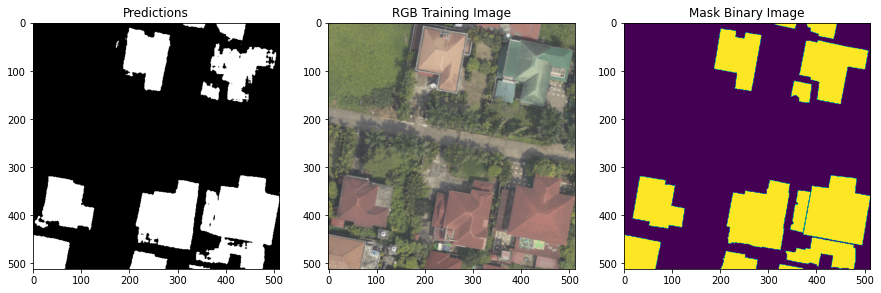

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

val_img_dir = '/content/sample_data/processed_image+final_00013_a0.png'
pred_pil = Image.open(val_img_dir)
pred_img = np.expand_dims(pred_pil, axis = 0)
val_preds = model.predict(pred_img)
mask_img_dir='/content/sample_data/mask_00013_a0.png'
mask_img = Image.open(mask_img_dir)
preds = np.argmax(val_preds[0], axis=-1)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(preds, cmap = 'gray')
plt.title('Predictions')
plt.subplot(132)
plt.imshow(pred_pil)
plt.title('RGB Training Image')
plt.subplot(133)
plt.imshow(mask_img)
plt.title('Mask Binary Image')

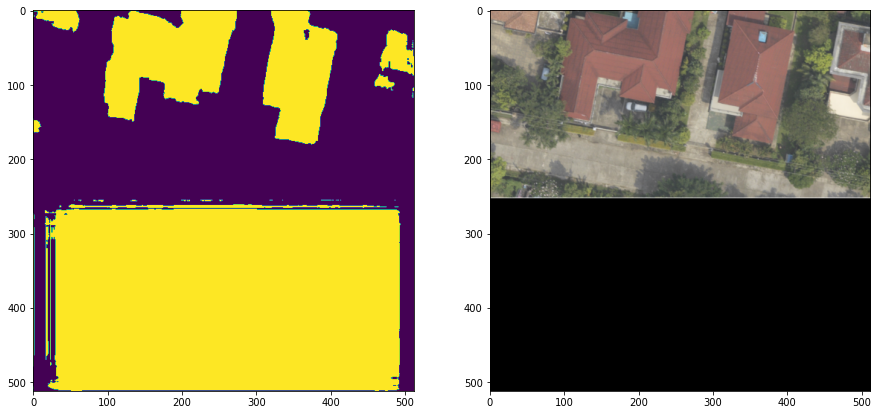

In [ ]:
img, msk = val_gen[0]
preds = model.predict(img)
preds = np.argmax(preds,axis=-1)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(np.squeeze(preds))
plt.subplot(122)
plt.imshow(np.squeeze(img).astype('uint8'))

In [ ]:
model.save('/content/unet_building_detection_epoch1000.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
